In [120]:
# Import modules
from matplotlib import pyplot as plt
import numpy as np
import math
import scipy
import pandas as pd
import glob, os
from sklearn import linear_model

In [171]:
# Error calculations
def error_prep_calc(x,y,intercept='VARIABLE'):
    if intercept == 'FIXED':
        xy = x * y
        x_squared = x**2
        n = len(x)

        m = sum(xy)/sum(x_squared)

        #predicted y
        y_hat = [m * xi for xi in x]

        y_dif = (y - y_hat)**2

        #std dev of regression
        Sr = (sum(y_dif)/(n-2))**0.5

        #std dev of slope
        Sm = ((n*Sr**2)/(n*sum(x_squared)-sum(x)**2))**0.5

        #Calculate critical value for 95% confidence interval 
        crit_t = scipy.stats.t.ppf(1-0.025, n-2)

        #slope confidence interval
        t_Sm = crit_t*Sm

    elif intercept == 'VARIABLE':
        xy = x * y
        x_squared = x**2
        n = len(x)

        m = (n * sum(xy) - sum(x) * sum(y))/(n * sum(x_squared) - sum(x)**2)

        c = (sum(y) - m * sum(x))/n

        #Eq is y = mx + c
        # To use regression through the origin you can instead use: sum(xy)/sum(x_squared) to calculate m

        #predicted y
        y_hat = [m * xi + c for xi in x]

        y_dif = (y - y_hat)**2

        #std dev of regression
        Sr = (sum(y_dif)/(n-2))**0.5

        #std dev of slope
        Sm = ((n*Sr**2)/(n*sum(x_squared)-sum(x)**2))**0.5

        #std dev of intercept
        Sc = ((Sr**2*sum(x_squared))/(n*sum(x_squared)-sum(x)**2))**0.5

        #Calculate critical value for 95% confidence interval 
        crit_t = scipy.stats.t.ppf(1-0.025, n-2)

        #slope confidence interval
        t_Sm = crit_t*Sm

        #intercept confidence interval
        t_Sc = crit_t*Sc

    else:
        raise TypeError("Intercept should be FIXED or VARIABLE")
    return x, y, Sr, m, n, np.mean(y), np.mean(x), crit_t

def simple_error_calc(x, y, Sr, m, n, mean_y, mean_x, sample, crit_t, reps=1):

    conc = sample/m

    #std dev sample conc
    S_sample = (Sr/m)*(1/reps + 1/n + ((sample-mean_y)/(m**2)*sum(x-mean_x)))**0.5

    t_Sm_sample = crit_t*S_sample
    
    return(conc, t_Sm_sample)

In [200]:
def file_import(path,file_extension,tstart = 140, tstop = 175):
    #import the list of files and sort them
    file_list = glob.glob(os.path.join(path, '*.'+str(file_extension)))
    no_files = len(file_list)

    #Create df to store integrated data
    if file_extension == 'TXT':
        with open(file_list[0]) as f:
            first_line = f.readline().strip('\n')
        elements = (first_line[first_line.index(':')+1:][1:]+'').split(',')
        summarydf = pd.DataFrame(columns=elements)
    elif file_extension == 'FIN2':
        with open(file_list[0]) as f:
            var_list = f.readlines()[7][:-1]
        elements = var_list.split(',')
        summarydf = pd.DataFrame(columns=elements[1:])
    else:
        raise TypeError("File Extension should be either TXT or FIN2")
    #print number of files and file list
    print(no_files)
    print('Elements',summarydf.keys())
    
    TRA_fig,axs = plt.subplots(figsize=(16,25),nrows = math.ceil(len(elements)/3),ncols = 3)
    plt.subplots_adjust(hspace=0.4,wspace=0.3)
    axs=axs.flatten()

    # CHOOSE BACKGROUND RUN NAME (shouldn't need to change)
    if file_extension == 'TXT':
        for file in file_list:
            with open(file) as f:
                first_line = f.readline().strip('\n')
            colnames = ('Time'+first_line[first_line.index(':')+1:]+'').split(',')
            if '_0ppb' in file:
                    backgrounddf = pd.read_csv(file,delimiter=',',header = 4, names=colnames,index_col=False)
    elif file_extension == 'FIN2':
        for file in file_list:
            with open(file) as f:
                first_line = f.readline()[7].strip('\n')
            colnames = var_list.split(',')#('Time'+first_line[first_line.index(':')+1:]+'').split(',')
            if '_0ppb' in file:
                    backgrounddf = pd.read_csv(file,delimiter=',',header = 7, names=colnames,index_col=False)
                    
    for file in file_list:
        if file_extension == 'TXT':
            with open(file) as f:
                first_line = f.readline().strip('\n')
            colnames = ('Time'+first_line[first_line.index(':')+1:]+'').split(',')
            df = pd.read_csv(file,delimiter=',',header = 4, names=colnames,index_col=False)
            # Separate name of sample
            text = file.replace(path+'/','')
            sep = '.'
            stripped = text.split(sep, 1)[0]
            name = stripped.removeprefix(path)
        elif file_extension == 'FIN2':
            with open(file) as f:
                first_line = f.readline()[7].strip('\n')
            colnames = var_list.split(',')#('Time'+first_line[first_line.index(':')+1:]+'').split(',')
            df = pd.read_csv(file,delimiter=',',header = 7, names=colnames,index_col=False)
            # Separate name of sample
            text = file.replace(path+'/','')
            sep = '.'
            stripped = text.split(sep, 1)[0]
            name = stripped.removeprefix(path)
        results = []


        for i, variable in enumerate(df.keys()):
            if variable in ['Time']:#,'As75(LR)', 'Se77(LR)', 'Se78(LR)', 'Se82(LR)', 'Mo95(LR)', 'Mo97(LR)', 'Ag107(LR)', 'Ag109(LR)', 'Cd111(LR)', 'Cd114(LR)', 'In115(LR)', 'Sn118(LR)', 'La139(LR)', 'Nd146(LR)', 'Ta181(LR)', 'Pb204(LR)', 'Pb206(LR)', 'Pb207(LR)', 'Pb208(LR)', 'Hg200(LR)']:
                ind=0
                continue
            else:
                axs[ind].plot(df['Time'],df[variable],label=name)
                axs[ind].set_xlabel('Time (s)')
                axs[ind].set_ylabel('Signal (counts)')
                # # Precon Mode (when running TRA for precon only runs)
                # CHANGE THE BEGINNING AND END OF THE INTEGRATION (IF NECESSARY)
                #tstart = 140
                #tstop = 175

                axs[ind].axvspan(xmin = df['Time'][tstart], xmax = df['Time'][tstop],alpha=0.1,color='k')
                if file_extension == 'TXT':
                    results.append((sum(df[variable][tstart:tstop])/sum(df['In115(LR)'][tstart:tstop]))-(sum(backgrounddf[variable][tstart:tstop])/sum(backgrounddf['In115(LR)'][tstart:tstop])))
                elif file_extension == 'FIN2':
                    results.append((sum(df[variable][tstart:tstop])/sum(df['In115'][tstart:tstop]))-(sum(backgrounddf[variable][tstart:tstop])/sum(backgrounddf['In115'][tstart:tstop])))
                axs[ind].set_title(variable)
                # axs[ind].set_xlim(450,550)
                # axs[ind].set_xlim(0,750)
                # axs[ind].legend()
                ind=ind+1
        summarydf.loc[name]=results
    # axs[9].set_ylim((0,1e6))
    display(summarydf.sort_index())
    return summarydf, elements

def calibration_calculation(summarydf, cal_stds,min_r2, elements):
    fig,axs = plt.subplots(figsize=(16,30),nrows = math.ceil(len(elements)/3),ncols = 3)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    axs=axs.flatten()

    # Calculate std concentrations based on dilutions
    STDdf = summarydf.filter(like='STD', axis=0)
    stds = np.zeros(len(STDdf))
    for i, text in enumerate(STDdf.index):
        stripped = text.split('_')
        std = 'cal_'+stripped[1]
        dil = stripped[2].replace('x','')
        stds[i]=cal_stds[std]/eval(dil)
    # calibration line
    cal = np.zeros(len(summarydf.keys()))
    error_cal = []

    for i, variable in enumerate(STDdf):
        # No need to calculate calibration line for internal standard as normalising based on it
        if 'In115' in variable:
            cal[i]=math.nan
            error_cal.append(np.empty(8))
            print(error_cal)
        else:
            x = stds
            y = STDdf[variable]

            axs[i].scatter(x,y,c='k')
            axs[i].set_title(variable)
            axs[i].set_xlabel('Concentration (ppb)')
            axs[i].set_ylabel('Signal normalised to In minus background')

            #Best fit 
            lm = linear_model.LinearRegression(fit_intercept = False)
            model = lm.fit(x.reshape(-1, 1),np.array(y))
            rsquared = lm.score(x.reshape(-1, 1),np.array(y))
            cal[i] = model.coef_[0]
            xrange = np.array([min(x),max(x)]).reshape(-1,1)
            ypred = lm.predict(xrange)
                    # Set quality limit on required r2 for correlation line and save value for concentration calculation in samples
            if rsquared < min_r2:
                cal[i]=math.nan
                axs[i].plot(xrange,ypred,'r--')
                axs[i].text(0.1,0.9,'$R^2 = {0:.5f}$'.format(rsquared),c='r',transform=axs[i].transAxes)
            else:
                axs[i].plot(xrange,ypred,'g--')
                axs[i].text(0.1,0.9,'$R^2 = {0:.5f}$'.format(rsquared),c='g',transform=axs[i].transAxes)
                lm = linear_model.LinearRegression(fit_intercept = False)
                model = lm.fit(np.array(y).reshape(-1, 1),x)
                score = lm.score(np.array(y).reshape(-1, 1),x)
                cal[i] = model.coef_[0]
                error_cal.append(error_prep_calc(np.array(x),np.array(y),intercept='FIXED'))

    concentrations=summarydf.copy()
    errors=summarydf.copy()
    for i, variable in enumerate(concentrations):
        concentrations[variable]=cal[i]*summarydf[variable]
        # x,y,Sr,m,n,mean_y,mean_x,crit_t = error_cal[i]
        # errors[variable] = simple_error_calc(x,y,Sr,m,n,mean_y,mean_x,crit_t,summarydf[variable])[1]
    return concentrations, errors

17
Elements Index(['Al27', 'As75', 'Se77', 'Se78', 'Se82', 'Ag107', 'Ag109', 'Cd111',
       'Cd114', 'In115', 'Sn118', 'La139', 'Nd146', 'Pb204', 'Pb206', 'Pb207',
       'Pb208', 'Hg200', 'Kr83'],
      dtype='object')


,Al27,As75,Se77,Se78,Se82,Ag107,Ag109,Cd111,Cd114,In115,Sn118,La139,Nd146,Pb204,Pb206,Pb207,Pb208,Hg200,Kr83
CON_Blank_10x,0.140754,0.079050,0.020148,-0.026406,-3.770686e-07,-0.000223,-0.000034,0.000018,0.000061,0.0,0.000155,0.000066,-0.000068,-0.000039,0.000032,-0.000043,0.000113,0.000006,-0.000271
SMP_Blank,-0.226253,-0.115598,-0.035615,0.042414,1.332152e-04,0.001812,-0.000063,0.000072,-0.000045,0.0,-0.000359,0.000943,0.000196,-0.000134,0.000126,0.000199,0.000141,-0.000018,-0.000426
SMP_SW_10x,-0.123570,-0.117077,-0.033268,0.127123,7.472562e-04,0.002000,-0.000106,0.000238,0.000506,0.0,-0.000131,0.000978,0.000098,0.000030,0.001336,0.000589,0.002200,0.000250,-0.000116
SMP_SW_1x,-0.263899,-0.090260,-0.028140,0.058477,4.130055e-03,0.001016,-0.000102,0.003236,0.005839,0.0,0.006951,0.007993,0.000504,0.001973,0.007587,0.006061,0.013962,0.007492,-0.000675
SMP_SW_2x,-0.200518,-0.113531,-0.034977,-0.052121,1.427624e-03,0.001942,-0.000276,0.001678,0.002459,0.0,0.003596,0.003957,0.000223,0.000698,0.004147,0.003361,0.006594,0.002255,-0.000597
SMP_SW_5x,-0.189791,-0.113859,-0.035209,0.019182,7.252069e-04,0.002413,-0.000170,0.000460,0.000893,0.0,0.000641,0.001730,0.000094,0.000271,0.001915,0.001692,0.003224,0.000855,-0.000053
SMP_s1,-0.164888,-0.100306,-0.034500,0.033781,9.290262e-04,0.000625,-0.000131,0.013369,0.027766,0.0,0.001291,0.020853,0.002260,0.004210,0.060776,0.053843,0.121915,0.000655,-0.001426
SMP_s5,0.425467,-0.101480,-0.031694,0.085838,6.736423e-04,0.002517,0.001266,0.019745,0.038246,0.0,0.021041,0.023769,0.001818,0.006601,0.119064,0.100177,0.235460,0.000362,-0.001051
SMP_s9,0.769677,-0.100689,-0.032441,0.080411,7.908428e-04,0.000999,-0.000065,0.020913,0.038466,0.0,0.003405,0.026721,0.002445,0.001422,0.023244,0.018588,0.043628,0.000290,-0.000748
STD_0ppb_1x,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


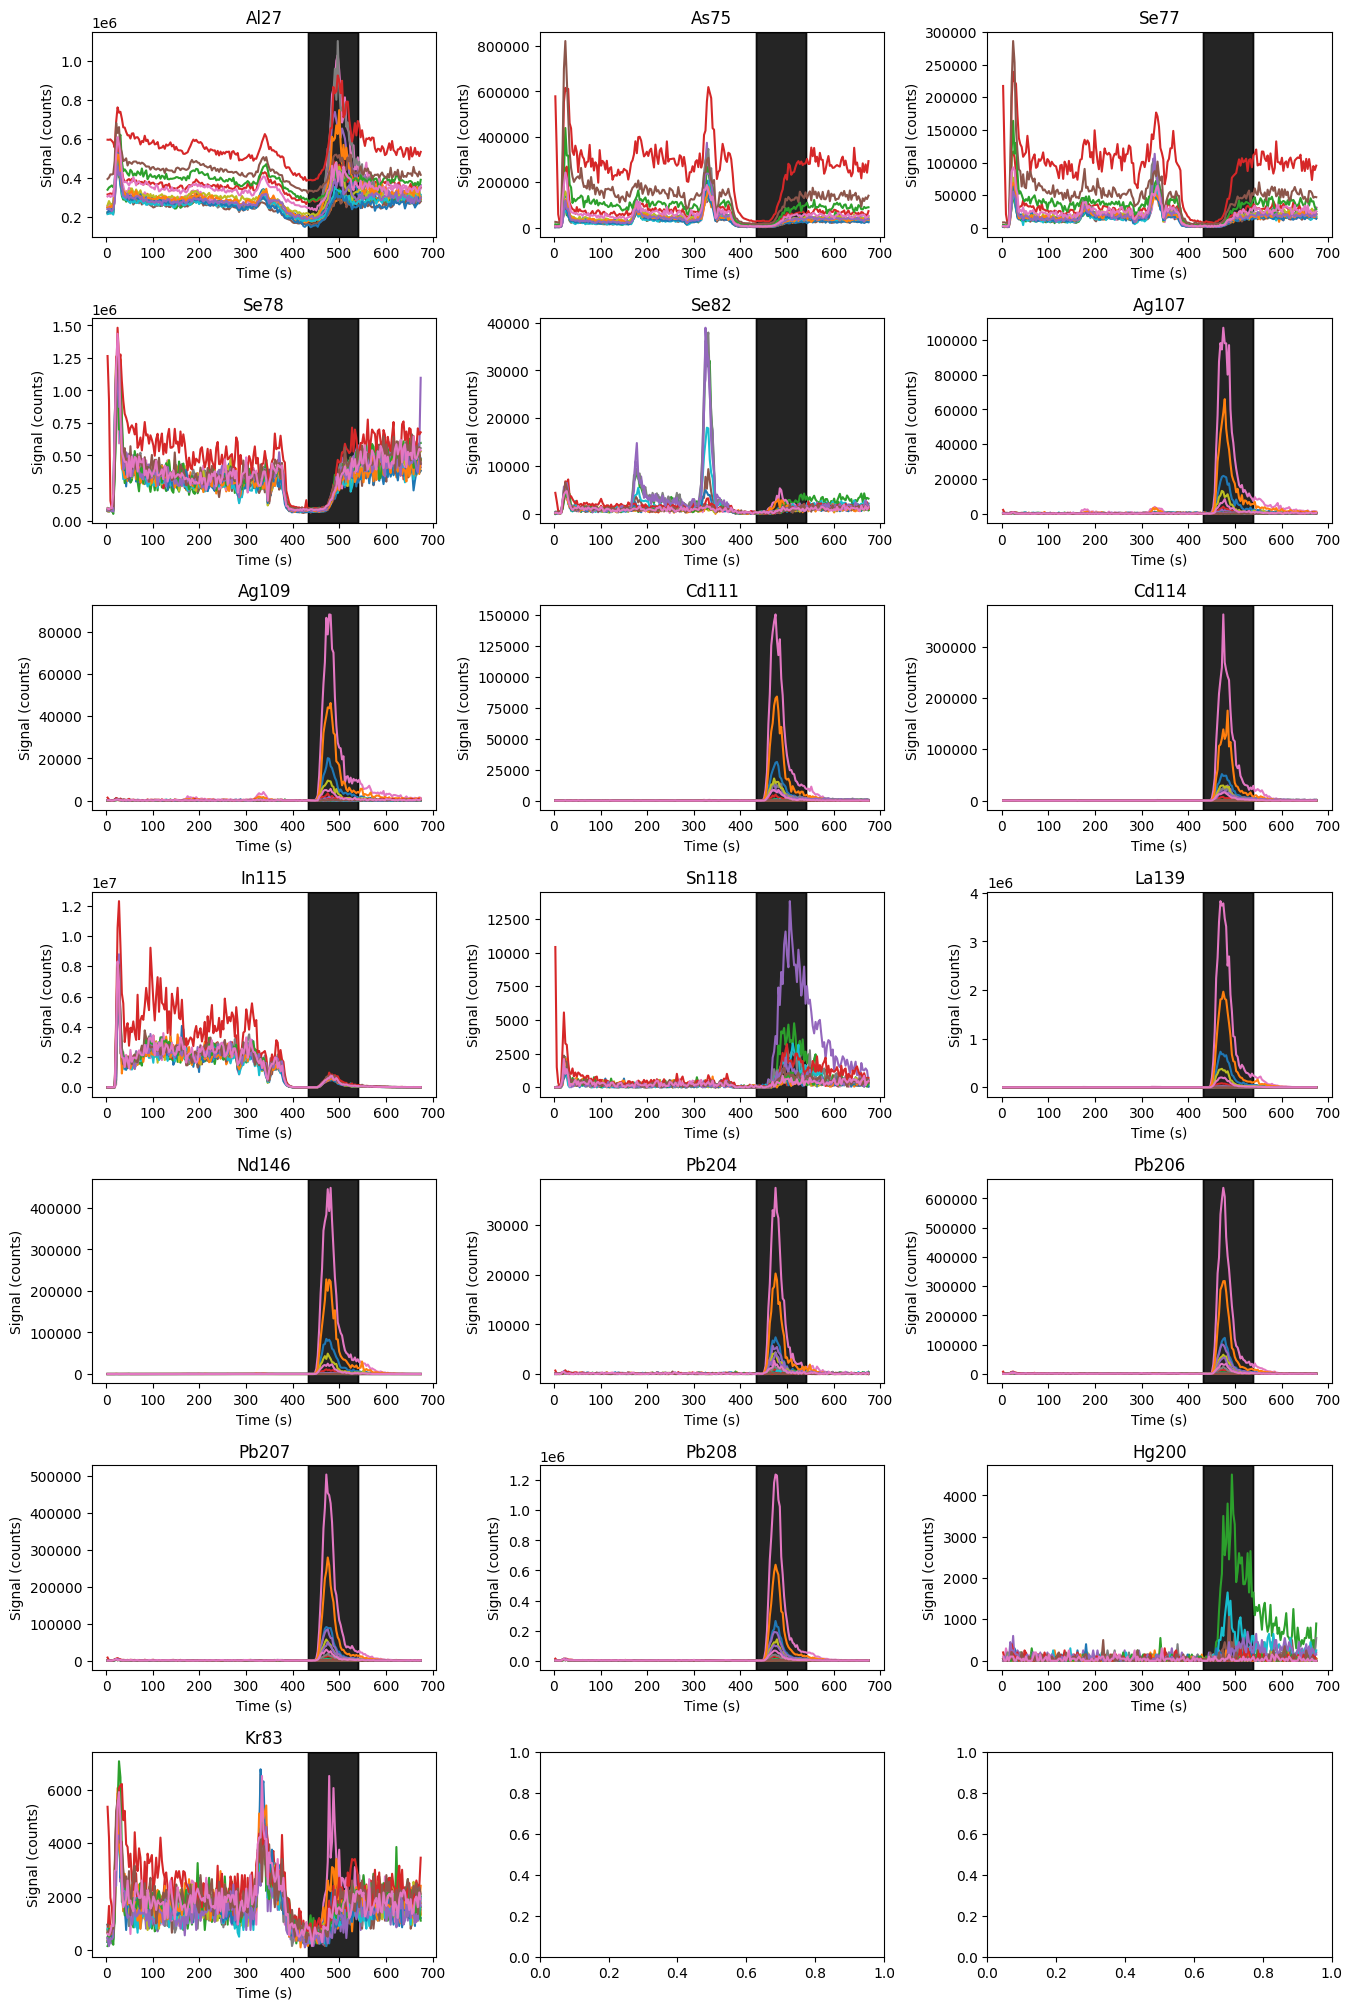

In [188]:
# SET THE DIRECTORY WHERE THE FILES ARE (These are the individual TRA files from the Element)
path = '/Users/hjb62/Python/ICP-MS TRA/Vl-May8-24-Seafast-precononly-test1/'
file_extension='FIN2'
# tstop=155
summarydf, elements = file_import(path,file_extension)

[(array([0.19408 , 0.019408, 0.9704  , 0.09704 , 0.4852  , 0.      ,
       0.04852 ]), array([0.21191865, 0.07364887, 1.12061678, 0.10178692, 0.56286371,
       0.        , 0.01308339]), 0.030732052340475297, 1.1521781624766945, 7, 0.2977026180427383, 0.25923542857142856, 2.5705818366147395), (array([0.19408 , 0.019408, 0.9704  , 0.09704 , 0.4852  , 0.      ,
       0.04852 ]), array([1.22872272e-03, 2.37342207e-05, 5.74542225e-03, 5.41978043e-04,
       3.31707063e-03, 0.00000000e+00, 3.07460752e-04]), 0.00018522357878809277, 0.0061057811148512685, 7, 0.0015949126591793261, 0.25923542857142856, 2.5705818366147395), (array([0.19408 , 0.019408, 0.9704  , 0.09704 , 0.4852  , 0.      ,
       0.04852 ]), array([0.03558085, 0.00388965, 0.16717287, 0.01734574, 0.08651231,
       0.        , 0.00874685]), 0.001482288857314394, 0.17384241389243513, 7, 0.04560689486139808, 0.25923542857142856, 2.5705818366147395), (array([0.19408 , 0.019408, 0.9704  , 0.09704 , 0.4852  , 0.      ,
       0.04

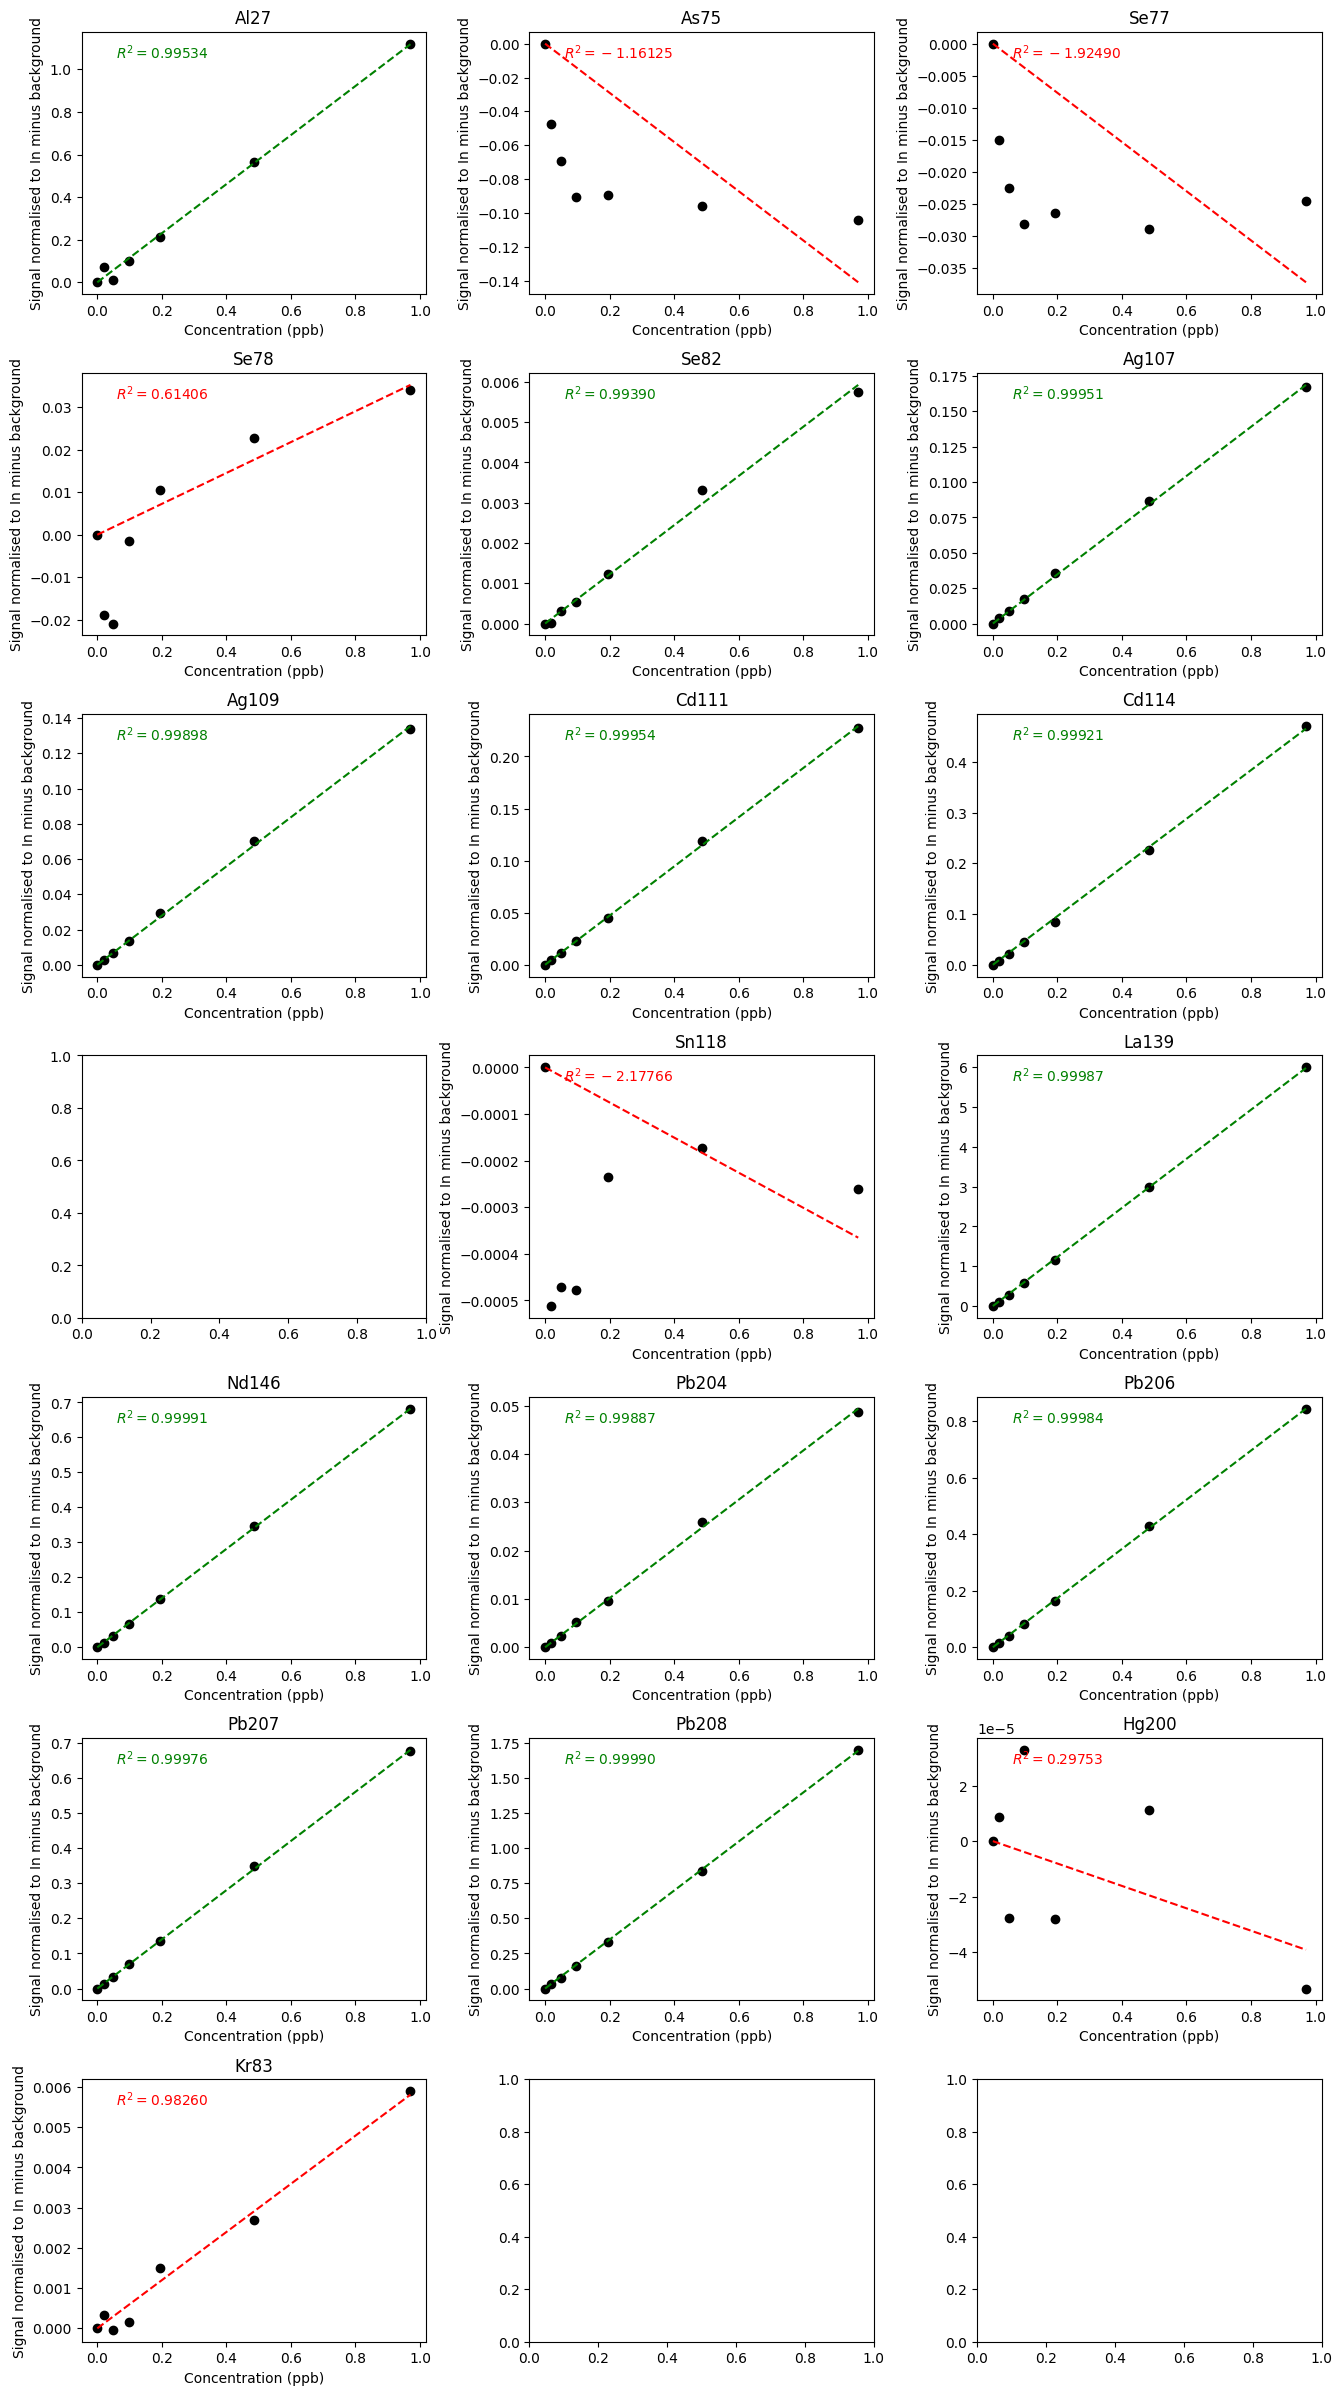

In [201]:
# ENTER STANDARD VALUES HERE (KEEP NAME FORMAT AS cal_ + standard concentration in ppb + ppb)
cal_stds = {'cal_100ppb': 99.8508, 'cal_10ppb': 8.9453, 'cal_1ppb': 0.9704, 'cal_0ppb': 0}

#Minimum r2 on calibrations
min_r2 = 0.99

concs, errors = calibration_calculation(summarydf, cal_stds, min_r2, elements)


In [112]:
display(concs.sort_index())
concs.to_csv('results.csv')

,Al27,As75,Se77,Se78,Se82,Ag107,Ag109,Cd111,Cd114,In115,Sn118,La139,Nd146,Pb204,Pb206,Pb207,Pb208,Hg200,Kr83
CON_Blank_10x,0.121810,NaN,NaN,NaN,-0.000062,-0.001283,-0.000246,0.000077,0.000128,NaN,NaN,0.000011,-0.000097,-0.000766,0.000037,-0.000061,0.000065,NaN,NaN
SMP_Blank,-0.195802,NaN,NaN,NaN,0.021736,0.010419,-0.000451,0.000304,-0.000095,NaN,NaN,0.000153,0.000279,-0.002624,0.000145,0.000284,0.000081,NaN,NaN
SMP_SW_10x,-0.106939,NaN,NaN,NaN,0.121928,0.011502,-0.000756,0.001006,0.001055,NaN,NaN,0.000159,0.000139,0.000586,0.001534,0.000841,0.001261,NaN,NaN
SMP_SW_1x,-0.228382,NaN,NaN,NaN,0.673890,0.005842,-0.000729,0.013703,0.012170,NaN,NaN,0.001296,0.000716,0.038753,0.008712,0.008650,0.008000,NaN,NaN
SMP_SW_2x,-0.173530,NaN,NaN,NaN,0.232941,0.011167,-0.001976,0.007107,0.005124,NaN,NaN,0.000642,0.000317,0.013707,0.004762,0.004797,0.003778,NaN,NaN
SMP_SW_5x,-0.164247,NaN,NaN,NaN,0.118330,0.013876,-0.001217,0.001947,0.001860,NaN,NaN,0.000280,0.000134,0.005323,0.002199,0.002414,0.001847,NaN,NaN
SMP_s1,-0.142696,NaN,NaN,NaN,0.151587,0.003594,-0.000939,0.056613,0.057870,NaN,NaN,0.003382,0.003215,0.082677,0.069788,0.076841,0.069853,NaN,NaN
SMP_s5,0.368205,NaN,NaN,NaN,0.109916,0.014474,0.009069,0.083609,0.079714,NaN,NaN,0.003855,0.002586,0.129631,0.136718,0.142965,0.134910,NaN,NaN
SMP_s9,0.666088,NaN,NaN,NaN,0.129040,0.005747,-0.000469,0.088555,0.080172,NaN,NaN,0.004333,0.003478,0.027916,0.026690,0.026528,0.024997,NaN,NaN
STD_0ppb_1x,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
